# VAE Latent Risk Factor - Pipeline Dashboard

Central configuration and execution notebook for the full walk-forward validation pipeline.

**Workflow:**
1. Configure all parameters (Sections 1-2)
2. Load data (Section 3)
3. Run pipeline (Section 4)
4. Inspect results (Sections 5-7)

---
## 1. Setup

In [1]:
import os
import sys
import logging
from dataclasses import replace, asdict
from pathlib import Path

import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

# Project root: go up from notebooks/ to project root
_NB_DIR = Path(os.path.abspath("")).resolve()
PROJECT_ROOT = (_NB_DIR / "..").resolve() if _NB_DIR.name == "notebooks" else _NB_DIR
os.chdir(PROJECT_ROOT)
sys.path.insert(0, str(PROJECT_ROOT))

from src.config import (
    PipelineConfig,
    DataPipelineConfig,
    VAEArchitectureConfig,
    LossConfig,
    TrainingConfig,
    InferenceConfig,
    RiskModelConfig,
    PortfolioConfig,
    WalkForwardConfig,
)
from src.data_pipeline.data_loader import load_data_source
from src.data_pipeline.returns import compute_log_returns
from src.data_pipeline.features import compute_trailing_volatility
from src.integration.pipeline import FullPipeline
from src.integration.reporting import export_results, format_summary_table
from src.integration.visualization import (
    plot_fold_metrics,
    plot_e_star_distribution,
    plot_pairwise_heatmap,
    style_summary_table,
    style_fold_table,
)
from src.utils import get_optimal_device
from src.walk_forward.selection import aggregate_fold_metrics, summary_statistics

%matplotlib inline
plt.rcParams["figure.dpi"] = 120

logging.basicConfig(level=logging.INFO, format="%(asctime)s [%(levelname)s] %(name)s: %(message)s")
logger = logging.getLogger("dashboard")

print(f"PyTorch {torch.__version__} | Device: {get_optimal_device()}")
print(f"Working directory: {os.getcwd()}")

/Users/mathis/Latent_risk_factor/Latent_risk_factor/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2026-02-07 21:47:12,197 [INFO] src.utils: Device auto-detected: MPS (Apple Silicon)


PyTorch 2.10.0 | Device: mps
Working directory: /Users/mathis/Latent_risk_factor/Latent_risk_factor


---
## 2. Configuration

Two configuration profiles are available. **Run ONLY one section:**
- **Section 2a** — Synthetic data: minimal parameters for quick end-to-end testing
- **Section 2b** — Real data: full production configuration

Always run the **Global** cell (below) first, then choose ONE section.

In [2]:
# ============================================================
# GLOBAL
# ============================================================
SEED = 42
DEVICE = str(get_optimal_device())

# Data source: "synthetic", "tiingo", or "csv"
DATA_SOURCE = "tiingo"
QUICK_MODE = True  # Set True for minimal config even with real data

# Tiingo API keys (used when DATA_SOURCE = "tiingo")
TIINGO_API_KEYS = [
    "9ba6e57788deaac3b3c38ed47047cabbbd6077e2",
    "9aad315d49275c400687f41dd26b22328d8b1a26",
]
DATA_DIR = "data/"  # Directory for Tiingo downloaded data

2026-02-07 21:47:12,203 [INFO] src.utils: Device auto-detected: MPS (Apple Silicon)


### 2a. Quick Mode

Run **only this cell** to configure the pipeline for a minimal end-to-end test. Skip Section 2b entirely.

In [ ]:
# ============================================================
# SYNTHETIC — Minimal config for end-to-end testing
# Run ONLY this cell, then jump to Section 3
# ============================================================

if QUICK_MODE == True or DATA_SOURCE == "synthetic":
    DATA_PATH = ""
    N_STOCKS = 10
    N_YEARS = 6

    # K=10 for speed; r_max relaxed because C_L floor (384) makes the CNN
    # too large for small synthetic universes — acceptable for testing only.
    config = PipelineConfig(
        data=DataPipelineConfig(
            n_stocks=N_STOCKS,
            window_length=504,
            n_features=2,
        ),
        vae=VAEArchitectureConfig(
            K=30,
            window_length=504,
            n_features=2,
            r_max=1e6,
        ),
        loss=LossConfig(mode="P"),
        training=TrainingConfig(
            max_epochs=5,
            batch_size=256,
            learning_rate=1e-4,
            patience=3,
        ),
        inference=InferenceConfig(),
        risk_model=RiskModelConfig(),
        portfolio=PortfolioConfig(n_starts=2),
        walk_forward=WalkForwardConfig(
            total_years=N_YEARS,
            min_training_years=max(3, N_YEARS // 3), # At least 3 years to avoid too-short training sets in early folds
            holdout_years=max(1, N_YEARS // 5), # At least 1 year holdout to ensure we have a test set in each fold
        ),
        seed=SEED,
    )

    HP_GRID = [{"mode": "P", "learning_rate": 1e-4, "alpha": 1.0}]

    print(f"[Quick mode] {N_STOCKS} stocks, {N_YEARS} years, K={config.vae.K}")
    print(f"  max_epochs={config.training.max_epochs}, patience={config.training.patience}, HP_GRID=1 config, n_starts=2")
    print(f"  r_max={config.vae.r_max:.0e} (relaxed for testing)")
    print(f"  Walk-forward: {config.walk_forward.total_years}y total, "
        f"{config.walk_forward.min_training_years}y min training, "
        f"{config.walk_forward.holdout_years}y holdout")
    print(f"  Device: {DEVICE}")

[Quick mode] 20 stocks, 8 years, K=10
  max_epochs=1, patience=1, HP_GRID=1 config, n_starts=2
  r_max=1e+06 (relaxed for testing)
  Walk-forward: 8y total, 3y min training, 1y holdout
  Device: mps


### 2b. Real Data (Production)

Run **all cells below** (through "ASSEMBLE FULL CONFIG") for full production configuration. Skip Section 2a.

In [4]:
# ============================================================
# DATA SOURCE — Real data
# ============================================================
# For CSV source:
DATA_PATH = "data/stock_data.csv"  # <-- Set path to your stock data CSV

# For Tiingo source: run download first:
#   python scripts/download_tiingo.py --phase all --keys-file keys.txt
# Then set DATA_SOURCE = "tiingo" in Global cell above.

# Universe and history parameters (overridden by synthetic cell if DATA_SOURCE == "synthetic")
N_STOCKS = 50                    # Top N stocks by median market cap (50=fast, 200=realistic, 0=all)
N_YEARS = 14                     # Years of history to keep (0=all)

In [5]:
# ============================================================
# DATA PIPELINE (MOD-001)
# ============================================================
data_cfg = DataPipelineConfig(
    n_stocks=N_STOCKS,           # universe cap (same as N_STOCKS above)
    window_length=504,           # T: sliding window length (trading days)
    n_features=2,                # F: features per timestep (return + realized vol)
    vol_window=252,              # trailing vol lookback (days)
    vix_lookback_percentile=80.0,# VIX percentile for crisis threshold
    min_valid_fraction=0.80,     # minimum valid data fraction per stock
)

In [6]:
# ============================================================
# VAE ARCHITECTURE (MOD-002)
# ============================================================
vae_cfg = VAEArchitectureConfig(
    K=200,                       # latent capacity ceiling
    sigma_sq_init=1.0,           # initial observation noise
    sigma_sq_min=1e-4,           # lower clamp for sigma^2
    sigma_sq_max=10.0,           # upper clamp for sigma^2
    window_length=504,           # T (must match data_cfg)
    n_features=2,                # F (must match data_cfg)
    r_max=5.0,                   # max parameter/data ratio (relaxed for synthetic)
)

print(f"Encoder depth L={vae_cfg.encoder_depth}, "
      f"Final width C_L={vae_cfg.final_layer_width}, "
      f"D={vae_cfg.D}")

Encoder depth L=5, Final width C_L=520, D=1008


In [7]:
# ============================================================
# LOSS FUNCTION (MOD-004)
# ============================================================
loss_cfg = LossConfig(
    mode="P",                    # 'P' (primary), 'F' (fallback), 'A' (advanced)
    gamma=3.0,                   # crisis overweighting factor
    lambda_co_max=0.5,           # max co-movement loss weight
    beta_fixed=1.0,              # fixed beta for Mode A
    warmup_fraction=0.20,        # fraction of epochs for Mode F warmup
    max_pairs=2048,              # max pairs for co-movement loss
    delta_sync=21,               # max date gap for synchronization (days)
)

In [8]:
# ============================================================
# TRAINING (MOD-005)
# ============================================================
training_cfg = TrainingConfig(
    max_epochs=100,              # maximum training epochs
    batch_size=256,              # batch size
    learning_rate=1e-4,          # initial learning rate (eta_0)
    weight_decay=1e-5,           # Adam weight decay
    adam_betas=(0.9, 0.999),     # Adam betas
    adam_eps=1e-8,               # Adam epsilon
    patience=10,                 # early stopping patience (epochs)
    lr_patience=5,               # ReduceLROnPlateau patience
    lr_factor=0.5,               # ReduceLROnPlateau factor
    n_strata=15,                 # strata for synchronous batching
    curriculum_phase1_frac=0.30, # fraction of epochs: sync+stratified batching
    curriculum_phase2_frac=0.30, # fraction of epochs: + co-movement loss ramp
)

In [9]:
# ============================================================
# INFERENCE (MOD-006)
# ============================================================
inference_cfg = InferenceConfig(
    batch_size=512,              # inference batch size
    au_threshold=0.01,           # KL threshold for active unit (nats)
    r_min=2,                     # min observations-per-parameter for AU_max
    aggregation_method="mean",   # profile aggregation method
)

In [10]:
# ============================================================
# RISK MODEL (MOD-007)
# ============================================================
risk_model_cfg = RiskModelConfig(
    winsorize_lo=5.0,            # lower percentile for vol ratio winsorization
    winsorize_hi=95.0,           # upper percentile
    d_eps_floor=1e-6,            # floor for idiosyncratic variance
    conditioning_threshold=1e6,  # condition number threshold for ridge fallback
    ridge_scale=1e-6,            # ridge regularization scale
)

In [11]:
# ============================================================
# PORTFOLIO OPTIMIZATION (MOD-008)
# Constraints identical for VAE and all 6 benchmarks (INV-012)
# ============================================================
portfolio_cfg = PortfolioConfig(
    lambda_risk=1.0,             # risk aversion
    w_max=0.05,                  # max weight per stock (hard cap)
    w_min=0.001,                 # min active weight (semi-continuous)
    w_bar=0.03,                  # concentration penalty threshold
    phi=25.0,                    # concentration penalty weight
    kappa_1=0.1,                 # linear turnover penalty
    kappa_2=7.5,                 # quadratic turnover penalty
    delta_bar=0.01,              # turnover penalty threshold
    tau_max=0.30,                # max one-way turnover (hard cap)
    n_starts=5,                  # multi-start initializations
    sca_max_iter=100,            # max SCA iterations
    sca_tol=1e-8,               # SCA convergence tolerance
    armijo_c=1e-4,               # Armijo sufficient decrease
    armijo_rho=0.5,              # Armijo backtracking factor
    armijo_max_iter=20,          # max Armijo backtracking steps
    max_cardinality_elim=100,    # max cardinality elimination rounds
    entropy_eps=1e-30,           # numerical stability for log()
    alpha_grid=[0.0, 0.01, 0.05, 0.1, 0.5, 1.0, 5.0],  # frontier alpha grid
)

In [12]:
# ============================================================
# WALK-FORWARD VALIDATION (MOD-009)
# ============================================================
walk_forward_cfg = WalkForwardConfig(
    total_years=N_YEARS,              # total history length
    min_training_years=10,       # minimum training window
    oos_months=6,                # out-of-sample period (months)
    embargo_days=21,             # embargo between train and OOS (trading days)
    holdout_years=3,             # final holdout period
    val_years=2,                 # nested validation for Phase A
    score_lambda_pen=5.0,        # MDD penalty weight in composite score
    score_lambda_est=2.0,        # estimation quality penalty weight
    score_mdd_threshold=0.20,    # MDD threshold in composite score
)

In [13]:
# ============================================================
# HP GRID for Phase A (set to None for default 18-config grid)
# ============================================================
HP_GRID = None  # None = default: 3 modes x 2 LRs x 3 alphas = 18 configs

# Uncomment to define a custom grid:
# HP_GRID = [
#     {"mode": "P", "learning_rate": 5e-4, "alpha": 1.0},
#     {"mode": "F", "learning_rate": 1e-3, "alpha": 0.5},
#     {"mode": "A", "learning_rate": 1e-3, "alpha": 2.0},
# ]

In [14]:
# ============================================================
# ASSEMBLE FULL CONFIG
# ============================================================
if DATA_SOURCE != "synthetic" and QUICK_MODE == False:
      config = PipelineConfig(
            data=data_cfg,
            vae=vae_cfg,
            loss=loss_cfg,
            training=training_cfg,
            inference=inference_cfg,
            risk_model=risk_model_cfg,
            portfolio=portfolio_cfg,
            walk_forward=walk_forward_cfg,
            seed=SEED,
      )

      print("PipelineConfig assembled.")
      print(f"  Walk-forward: {config.walk_forward.total_years}y total, "
            f"{config.walk_forward.min_training_years}y min training, "
            f"{config.walk_forward.holdout_years}y holdout")
      print(f"  VAE: K={config.vae.K}, T={config.vae.window_length}, F={config.vae.n_features}")
      print(f"  Training: {config.training.max_epochs} max epochs, "
            f"bs={config.training.batch_size}, lr={config.training.learning_rate}")
      print(f"  Loss mode: {config.loss.mode}, gamma={config.loss.gamma}")
      print(f"  Capacity guard r_max: {config.vae.r_max}")
      print(f"  Device: {DEVICE}")

---
## 3. Data Loading

### 3a. Tiingo Download (run once)

Run this cell **only once** to download Tiingo data. After the first run, the data is saved locally and reused automatically.
Set `MAX_TICKERS` to a small number (e.g. 5) for testing, or `None` for the full universe.

In [15]:
# ============================================================
# TIINGO DOWNLOAD — Run once, data is saved locally
# Skip this cell if data is already downloaded or DATA_SOURCE != "tiingo"
# ============================================================

if DATA_SOURCE == "tiingo":
    import importlib.util

    _spec = importlib.util.spec_from_file_location(
        "download_tiingo", str(PROJECT_ROOT / "scripts" / "download_tiingo.py")
    )
    _mod = importlib.util.module_from_spec(_spec)
    _spec.loader.exec_module(_mod)  # type: ignore[union-attr]

    MAX_TICKERS = None  # Set to None for full universe (~22k tickers)

    _mod.run_download(
        api_keys=TIINGO_API_KEYS,
        data_dir=DATA_DIR,
        max_tickers=MAX_TICKERS,
        sp500_first=True,  # Download SP500 tickers first (priority)
    )
else:
    print(f"DATA_SOURCE={DATA_SOURCE}, skipping Tiingo download.")

2026-02-07 21:47:12,322 [INFO] download_tiingo: Validating 2 API key(s)...
2026-02-07 21:47:12,692 [INFO] download_tiingo: Key #1 valid (masked: ...77e2)
2026-02-07 21:47:13,139 [INFO] download_tiingo: Key #2 valid (masked: ...1a26)
2026-02-07 21:47:13,143 [INFO] download_tiingo: 2/2 keys valid.
2026-02-07 21:47:13,143 [INFO] download_tiingo: === Phase 1: Ticker Discovery ===
2026-02-07 21:47:13,144 [INFO] download_tiingo: Downloading supported tickers list from Tiingo...
2026-02-07 21:47:13,799 [INFO] download_tiingo: Fetching S&P 500 constituent list from Wikipedia...
2026-02-07 21:47:14,126 [INFO] download_tiingo: Found 502 S&P 500 tickers from Wikipedia
2026-02-07 21:47:14,134 [INFO] download_tiingo: SP500 priority: 518 SP500 tickers first, then 21857 others
2026-02-07 21:47:14,169 [INFO] download_tiingo: Saved 22375 US equity tickers (6687 active, 15688 delisted) to data/tiingo_meta/supported_tickers.csv
2026-02-07 21:47:14,197 [INFO] download_tiingo: Assigned permnos to 22375 tic

In [16]:
np.random.seed(SEED)

stock_data, start_date = load_data_source(
    source=DATA_SOURCE,
    data_path=DATA_PATH if DATA_SOURCE == "csv" else "",
    data_dir=DATA_DIR,
    n_stocks=N_STOCKS,
    n_years=N_YEARS,
    seed=SEED,
)

print(f"Data source: {DATA_SOURCE}")
print(f"Stock data shape: {stock_data.shape}")
print(f"Date range: {stock_data['date'].min()} to {stock_data['date'].max()}")
print(f"Unique stocks: {stock_data['permno'].nunique()}")
stock_data.head()

Data source: tiingo
Stock data shape: (163294, 8)
Date range: 2012-02-06 00:00:00 to 2026-02-06 00:00:00
Unique stocks: 50


,permno,date,adj_price,volume,exchange_code,share_code,market_cap,delisting_return
0,10011,2012-02-06,4.346546,11290006,3,10,6.259263e+09,NaN
1,10011,2012-02-07,4.349293,13484930,3,10,6.120827e+09,NaN
2,10011,2012-02-08,4.335556,13438316,3,10,6.056733e+09,NaN
3,10011,2012-02-09,4.396001,22533946,3,10,6.128955e+09,NaN
4,10011,2012-02-10,4.434466,27789072,3,10,6.092940e+09,NaN


In [17]:
# Compute log-returns and trailing volatility
returns = compute_log_returns(stock_data)
trailing_vol = compute_trailing_volatility(returns, window=config.data.vol_window)

print(f"Returns: {returns.shape[0]} dates x {returns.shape[1]} stocks")
print(f"Trailing vol: {trailing_vol.shape} (first {config.data.vol_window-1} rows NaN)")
print(f"Returns date range: {returns.index[0]} to {returns.index[-1]}")

Returns: 3522 dates x 50 stocks
Trailing vol: (3522, 50) (first 251 rows NaN)
Returns date range: 2012-02-06 00:00:00 to 2026-02-06 00:00:00


---
## 4. Run Pipeline

Executes the full walk-forward validation: Phase A (HP selection) + Phase B (deployment) on each fold, then benchmarks, statistical tests, and report generation.

### TensorBoard Monitoring

Launch TensorBoard in a terminal to monitor training in real-time:

```bash
.venv/bin/tensorboard --logdir runs/
```

Logs are organized as `runs/fold_XX/phase_a/config_YY_mode_M_lr_L/` and `runs/fold_XX/phase_b/`.

**Step-level metrics** (logged every 50 batches) — raw per-batch values, useful to spot instabilities:

| Metric | What to look for |
|--------|-----------------|
| `Step/loss` | Should decrease overall. Spikes are normal early on. |
| `Step/reconstruction` | Main driver of total loss. Should decrease steadily. |
| `Step/kl_divergence` | Grows as the VAE learns to use latent dimensions. Too high = posterior collapse risk. |
| `Step/co_movement` | Ramps up during curriculum phase 2 (epochs 30-60%). Should stabilize. |
| `Step/sigma_sq` | Learned observation noise. Should settle between 0.01-1.0. |

**Epoch-level metrics** (logged once per epoch) — smoothed averages, useful for overall trends:

| Metric | What to look for |
|--------|-----------------|
| `Loss/total` | Overall training loss (lower = better). |
| `Validation/ELBO` | Key metric for early stopping. Gap with training loss = overfitting. |
| `Training/active_units` | Number of latent dimensions actually used (KL > 0.01 nats). Target: 15-80% of K. |
| `Training/learning_rate` | Should step down when validation plateaus (ReduceLROnPlateau). |
| `Training/lambda_co` | Co-movement weight schedule: 0 during phase 1, ramps to lambda_co_max during phase 2. |
| `Training/beta_t` | Beta annealing (Mode F only): 0 to 1 during warmup, then fixed at 1. |

**Quick diagnostic:**
- **Good training**: reconstruction drops, AU grows to 20-60, validation tracks training
- **Posterior collapse**: AU stays near 0, KL near 0 — try Mode F or lower learning rate
- **Overfitting**: validation diverges from training — early stopping should trigger

In [18]:
# Print training configuration summary
print("=" * 60)
print("PIPELINE CONFIGURATION SUMMARY")
print("=" * 60)
print(f"  Seed: {config.seed} | Device: {DEVICE} | Data: {DATA_SOURCE}")
print()
print(f"  [Data]         n_stocks={config.data.n_stocks}, T={config.data.window_length}, "
      f"F={config.data.n_features}, vol_window={config.data.vol_window}")
print(f"  [VAE]          K={config.vae.K}, L={config.vae.encoder_depth}, "
      f"C_L={config.vae.final_layer_width}, r_max={config.vae.r_max}")
print(f"  [Loss]         mode={config.loss.mode}, gamma={config.loss.gamma}, "
      f"lambda_co_max={config.loss.lambda_co_max}, beta_fixed={config.loss.beta_fixed}")
print(f"  [Training]     max_epochs={config.training.max_epochs}, bs={config.training.batch_size}, "
      f"lr={config.training.learning_rate}, wd={config.training.weight_decay}")
print(f"                 patience={config.training.patience}, lr_patience={config.training.lr_patience}, "
      f"lr_factor={config.training.lr_factor}")
print(f"                 curriculum: phase1={config.training.curriculum_phase1_frac}, "
      f"phase2={config.training.curriculum_phase2_frac}, strata={config.training.n_strata}")
print(f"  [Inference]    bs={config.inference.batch_size}, AU_threshold={config.inference.au_threshold}, "
      f"r_min={config.inference.r_min}")
print(f"  [Risk Model]   winsorize=[{config.risk_model.winsorize_lo}, {config.risk_model.winsorize_hi}], "
      f"cond_threshold={config.risk_model.conditioning_threshold:.0e}")
print(f"  [Portfolio]    w_max={config.portfolio.w_max}, w_min={config.portfolio.w_min}, "
      f"tau_max={config.portfolio.tau_max}, n_starts={config.portfolio.n_starts}")
print(f"  [Walk-Forward] {config.walk_forward.total_years}y total, "
      f"{config.walk_forward.min_training_years}y min train, "
      f"{config.walk_forward.oos_months}mo OOS, "
      f"{config.walk_forward.holdout_years}y holdout, "
      f"embargo={config.walk_forward.embargo_days}d")
n_hp = len(HP_GRID) if HP_GRID else "18 (default)"
print(f"  [HP Grid]      {n_hp} configs")
print("=" * 60)

TB_DIR = "runs/"  # TensorBoard log directory (set to None to disable)

pipeline = FullPipeline(config, tensorboard_dir=TB_DIR)

results = pipeline.run(
    stock_data=stock_data,
    returns=returns,
    trailing_vol=trailing_vol,
    skip_phase_a=(DATA_SOURCE == "synthetic" or QUICK_MODE == True),
    vix_data=None,
    start_date=start_date,
    hp_grid=HP_GRID,
    device=DEVICE,
)

print("Pipeline complete.")
print(f"Folds processed: {len(results['vae_results'])}")
print(f"Benchmarks: {list(results['benchmark_results'].keys())}")

2026-02-07 21:47:19,539 [INFO] src.integration.pipeline: Starting walk-forward: 8 folds + holdout
2026-02-07 21:47:19,540 [INFO] src.integration.pipeline: [Fold 0/8] Phase A skipped, using default config
2026-02-07 21:47:19,540 [INFO] src.integration.pipeline: [Fold 0/8] Phase B: deployment training


PIPELINE CONFIGURATION SUMMARY
  Seed: 42 | Device: mps | Data: tiingo

  [Data]         n_stocks=20, T=504, F=2, vol_window=252
  [VAE]          K=10, L=5, C_L=384, r_max=1000000.0
  [Loss]         mode=P, gamma=3.0, lambda_co_max=0.5, beta_fixed=1.0
  [Training]     max_epochs=1, bs=256, lr=0.0001, wd=1e-05
                 patience=1, lr_patience=5, lr_factor=0.5
                 curriculum: phase1=0.3, phase2=0.3, strata=15
  [Inference]    bs=512, AU_threshold=0.01, r_min=2
  [Risk Model]   winsorize=[5.0, 95.0], cond_threshold=1e+06
  [Portfolio]    w_max=0.05, w_min=0.001, tau_max=0.3, n_starts=2
  [Walk-Forward] 8y total, 3y min train, 6mo OOS, 1y holdout, embargo=21d
  [HP Grid]      18 (default) configs


2026-02-07 21:47:19,833 [INFO] src.integration.pipeline:   [Fold 0] Windowing: 10660 windows from 50 stocks, 756 train days
    Training: 100%|██████████| 38/38 [01:49<00:00,  2.89s/step, AU=10, epoch=1/1, loss=568.9120, lr=1.0e-04, val=502.9563]
2026-02-07 21:49:11,076 [INFO] src.integration.pipeline:   [Fold 0] Training: 1 epochs in 111.5s (best_epoch=0)
2026-02-07 21:49:11,077 [INFO] src.integration.pipeline:   [Fold 0] Inference: extracting latent profiles...
    Inference: 100%|██████████| 21/21 [00:12<00:00,  1.70batch/s]
2026-02-07 21:49:35,201 [INFO] src.integration.pipeline:   [Fold 0] AU=10 active units (max=27)
2026-02-07 21:49:36,327 [INFO] src.integration.pipeline:   [Fold 0] Dual rescaling done
2026-02-07 21:49:36,574 [INFO] src.integration.pipeline:   [Fold 0] Risk model: AU=10, B_A(44×10), Sigma(44×44)
2026-02-07 21:49:36,574 [INFO] src.integration.pipeline:   [Fold 0] Frontier: 7 alphas × 2 starts...
2026-02-07 21:49:36,574 [INFO] src.portfolio.frontier:     Frontier a

Pipeline complete.
Folds processed: 9
Benchmarks: ['equal_weight', 'inverse_vol', 'min_variance', 'erc', 'pca_factor_rp', 'pca_vol']


---
## 5. Results - Summary Report

In [29]:
# Text summary
print(format_summary_table(results["report"]))

VAE LATENT RISK FACTOR — RESULTS REPORT

Scenario: B
Recommendation: Review iterations (DVT Section 6)

E* epochs: mean=1.0, std=0.0, range=[1, 1]

Statistical Tests (18 comparisons, alpha=0.05):
--------------------------------------------------

  vs equal_weight:
    ann_vol_oos: Δ=-0.0081 [-0.0179, +0.0005] p=0.0781
    max_drawdown_oos: Δ=-0.0066 [-0.0353, +0.0003] p=0.1094
    sharpe: Δ=+0.0489 [-0.1573, +0.3837] p=0.5469

  vs inverse_vol:
    ann_vol_oos: Δ=+0.0009 [-0.0085, +0.0096] p=0.9453
    max_drawdown_oos: Δ=-0.0034 [-0.0199, +0.0041] p=0.1953
    sharpe: Δ=+0.1340 [-0.1626, +0.3309] p=0.3125

  vs min_variance:
    ann_vol_oos: Δ=+0.0145 [+0.0118, +0.0204] p=0.0078
    max_drawdown_oos: Δ=+0.0023 [-0.0113, +0.0130] p=0.6406
    sharpe: Δ=+0.4579 [-0.1904, +0.8432] p=0.0781

  vs erc:
    ann_vol_oos: Δ=+0.0010 [-0.0064, +0.0085] p=0.7422
    max_drawdown_oos: Δ=-0.0025 [-0.0138, +0.0030] p=0.1484
    sharpe: Δ=+0.0716 [-0.1580, +0.2424] p=0.3828

  vs pca_factor_rp:
  

In [30]:
# Deployment recommendation
deployment = results["report"]["deployment"]
print(f"Scenario: {deployment['scenario']}")
print(f"Recommendation: {deployment['recommendation']}")
print()
print("Per-benchmark wins (VAE vs benchmark on primary metrics):")
for bench, info in deployment["per_benchmark"].items():
    print(f"  {bench:20s}: {info['wins']}/{info['total']} metrics won")

Scenario: B
Recommendation: Review iterations (DVT Section 6)

Per-benchmark wins (VAE vs benchmark on primary metrics):
  equal_weight        : 3/4 metrics won
  inverse_vol         : 2/4 metrics won
  min_variance        : 1/4 metrics won
  erc                 : 1/4 metrics won
  pca_factor_rp       : 2/4 metrics won
  pca_vol             : 2/4 metrics won


In [31]:
# VAE summary statistics
vae_df = aggregate_fold_metrics(results["vae_results"])
vae_summary = summary_statistics(vae_df)
print("VAE Summary Statistics:")
style_summary_table(vae_summary)

VAE Summary Statistics:


,metric,mean,median,std,min,max,count
0,H_norm_oos,0.7559,0.7833,0.1407,0.5641,0.9293,9.0000
1,ann_vol_oos,0.1462,0.1443,0.0420,0.0897,0.2056,8.0000
2,max_drawdown_oos,0.1006,0.0932,0.0553,0.0322,0.1904,8.0000
3,ann_return,0.1380,0.1430,0.1030,-0.0323,0.2744,8.0000
4,sharpe,1.1085,1.1236,0.8441,-0.1573,2.3179,8.0000
5,calmar,1.9065,1.3492,1.8462,-0.1698,4.8803,9.0000
6,sortino,1.4523,1.4430,1.2203,-0.2071,3.7730,8.0000
7,eff_n_positions,21.9314,22.1078,0.5011,20.7992,22.4927,9.0000
8,diversification_ratio,1.4107,1.5557,0.5716,0.0000,1.9303,9.0000
9,n_active_positions,22.7778,23.0000,0.8333,21.0000,24.0000,9.0000


In [32]:
# Benchmark summary statistics
for bench_name, bench_metrics in results["benchmark_results"].items():
    bench_df = aggregate_fold_metrics(bench_metrics)
    bench_summary = summary_statistics(bench_df)
    print(f"\n{bench_name} Summary:")
    display(style_summary_table(bench_summary))


equal_weight Summary:


,metric,mean,median,std,min,max,count
0,ann_return,0.1334,0.1361,0.1453,-0.0940,0.2939,9.0000
1,ann_vol_oos,0.1529,0.1414,0.0473,0.0905,0.2391,9.0000
2,sharpe,1.1166,1.5043,1.1179,-0.4604,2.8120,9.0000
3,max_drawdown_oos,0.1111,0.0979,0.0677,0.0319,0.2334,9.0000
4,calmar,2.3429,2.4688,2.6046,-0.5674,7.6212,9.0000
5,eff_n_positions,44.6667,45.0000,0.5000,44.0000,45.0000,9.0000
6,fold_id,4.0000,4.0000,2.7386,0.0000,8.0000,9.0000



inverse_vol Summary:


,metric,mean,median,std,min,max,count
0,ann_return,0.1198,0.1254,0.1302,-0.0860,0.2518,9.0000
1,ann_vol_oos,0.1444,0.1375,0.0464,0.0801,0.2255,9.0000
2,sharpe,1.0703,1.5668,1.0517,-0.5104,2.5468,9.0000
3,max_drawdown_oos,0.1049,0.0875,0.0625,0.0268,0.2181,9.0000
4,calmar,2.1168,2.3508,2.1725,-0.6382,5.6719,9.0000
5,eff_n_positions,41.7046,41.7933,0.6288,40.8089,42.7161,9.0000
6,fold_id,4.0000,4.0000,2.7386,0.0000,8.0000,9.0000



min_variance Summary:


,metric,mean,median,std,min,max,count
0,ann_return,0.0909,0.1281,0.1158,-0.1158,0.2186,9.0000
1,ann_vol_oos,0.1286,0.1221,0.0419,0.0692,0.1956,9.0000
2,sharpe,0.8608,1.0334,0.8915,-0.7165,1.8940,9.0000
3,max_drawdown_oos,0.0938,0.0724,0.0532,0.0225,0.1997,9.0000
4,calmar,1.5043,1.8796,1.3373,-0.8646,3.0578,9.0000
5,eff_n_positions,21.9546,22.0644,0.6093,20.8621,22.6728,9.0000
6,fold_id,4.0000,4.0000,2.7386,0.0000,8.0000,9.0000



erc Summary:


,metric,mean,median,std,min,max,count
0,ann_return,0.1233,0.1267,0.1287,-0.0884,0.2482,9.0000
1,ann_vol_oos,0.1431,0.1358,0.0452,0.0811,0.2217,9.0000
2,sharpe,1.0963,1.5621,1.0430,-0.5241,2.5434,9.0000
3,max_drawdown_oos,0.1036,0.0856,0.0607,0.0282,0.2146,9.0000
4,calmar,2.1359,2.1972,2.1170,-0.6577,5.5256,9.0000
5,eff_n_positions,41.5760,41.7860,0.4518,40.6153,41.9732,9.0000
6,fold_id,4.0000,4.0000,2.7386,0.0000,8.0000,9.0000



pca_factor_rp Summary:


,metric,mean,median,std,min,max,count
0,ann_return,0.0893,0.0814,0.1207,-0.1007,0.2254,9.0000
1,ann_vol_oos,0.1407,0.1338,0.0419,0.0810,0.2048,9.0000
2,sharpe,0.8162,1.0049,0.9229,-0.5999,1.9943,9.0000
3,max_drawdown_oos,0.1077,0.0827,0.0581,0.0398,0.2156,9.0000
4,calmar,1.3821,1.9117,1.4346,-0.7216,3.4498,9.0000
5,eff_n_positions,32.9569,32.9674,0.0460,32.8833,32.9996,9.0000
6,fold_id,4.0000,4.0000,2.7386,0.0000,8.0000,9.0000



pca_vol Summary:


,metric,mean,median,std,min,max,count
0,ann_return,0.1616,0.2239,0.1532,-0.1089,0.3230,9.0000
1,ann_vol_oos,0.1608,0.1458,0.0455,0.1060,0.2393,9.0000
2,sharpe,1.2440,1.6084,1.1016,-0.5758,2.2991,9.0000
3,max_drawdown_oos,0.1128,0.0920,0.0683,0.0308,0.2276,9.0000
4,calmar,2.8052,2.4556,2.8580,-0.6816,7.6528,9.0000
5,eff_n_positions,20.0669,20.0000,0.1279,20.0000,20.3757,9.0000
6,fold_id,4.0000,4.0000,2.7386,0.0000,8.0000,9.0000


---
## 6. Results - Per-Fold Detail

In [33]:
# VAE per-fold metrics
print("VAE Per-Fold Metrics:")
style_fold_table(vae_df)

VAE Per-Fold Metrics:


,H_norm_oos,ann_vol_oos,max_drawdown_oos,ann_return,sharpe,calmar,sortino,eff_n_positions,diversification_ratio,n_active_positions,n_days_oos,AU,e_star,alpha_opt,var_ratio_oos,corr_rank_oos,explanatory_power,fold_id
0,0.6034,0.1749,0.1288,0.0275,0.1573,0.2137,0.1968,22.4927,1.3679,23.0000,129.0000,10.0000,1.0000,5.0000,0.5748,0.7170,0.5204,0.0000
1,0.6259,0.1899,0.1577,0.1601,0.8430,1.0154,1.2408,20.7992,1.5557,21.0000,124.0000,10.0000,1.0000,5.0000,1.2216,0.8025,0.5032,1.0000
2,0.5641,0.1202,0.0614,0.2016,1.6770,3.2849,1.9449,22.1249,1.2592,23.0000,129.0000,10.0000,1.0000,5.0000,0.1894,0.5631,0.5417,2.0000
3,0.7833,0.1008,0.0479,0.2336,2.3179,4.8803,3.7730,22.3755,1.6326,24.0000,125.0000,10.0000,1.0000,5.0000,0.2357,0.6294,0.5511,3.0000
4,0.9293,0.0897,0.0322,0.1259,1.4042,3.9113,1.6451,22.1648,1.8754,23.0000,129.0000,10.0000,1.0000,5.0000,0.2343,0.4888,0.5242,4.0000
5,0.6782,0.1534,0.1026,0.2744,1.7886,2.6736,1.9461,21.7671,1.4656,23.0000,125.0000,10.0000,1.0000,5.0000,0.4604,0.4206,0.5152,5.0000
6,0.9199,0.1352,0.0838,0.1131,0.8369,1.3492,1.0788,22.1078,1.9303,23.0000,128.0000,10.0000,1.0000,5.0000,1.2396,0.7900,0.4696,6.0000
7,0.8518,0.2056,0.1904,-0.0323,-0.1573,-0.1698,-0.2071,21.6866,1.6092,22.0000,106.0000,10.0000,1.0000,5.0000,1.6179,0.6046,0.4885,7.0000
8,0.8475,nan,nan,nan,nan,0.0000,nan,21.8637,0.0000,23.0000,232.0000,10.0000,1.0000,5.0000,0.6550,0.7034,0.5254,8.0000


E* epochs: mean=1.0, std=0.0, range=[1, 1]


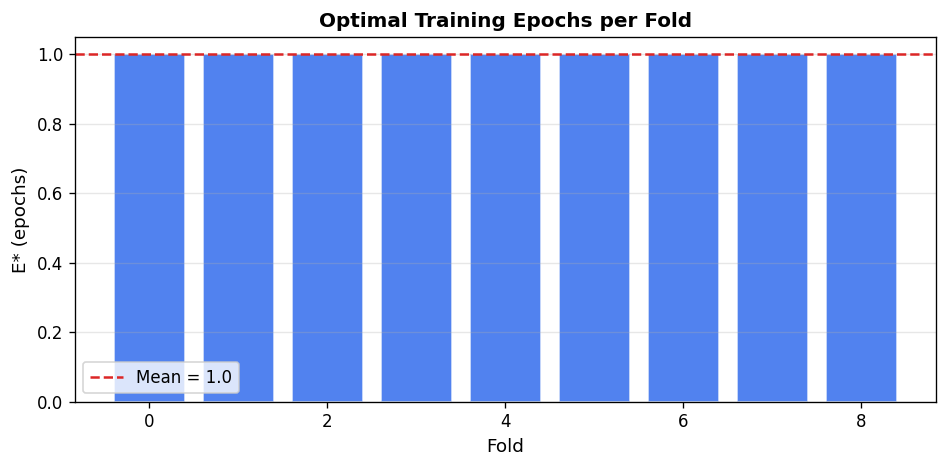

In [34]:
# E* distribution
e_star_summary = results["report"]["e_star_summary"]
print(f"E* epochs: mean={e_star_summary['mean']:.1f}, "
      f"std={e_star_summary['std']:.1f}, "
      f"range=[{e_star_summary['min']}, {e_star_summary['max']}]")

plot_e_star_distribution(results["e_stars"])
plt.show()

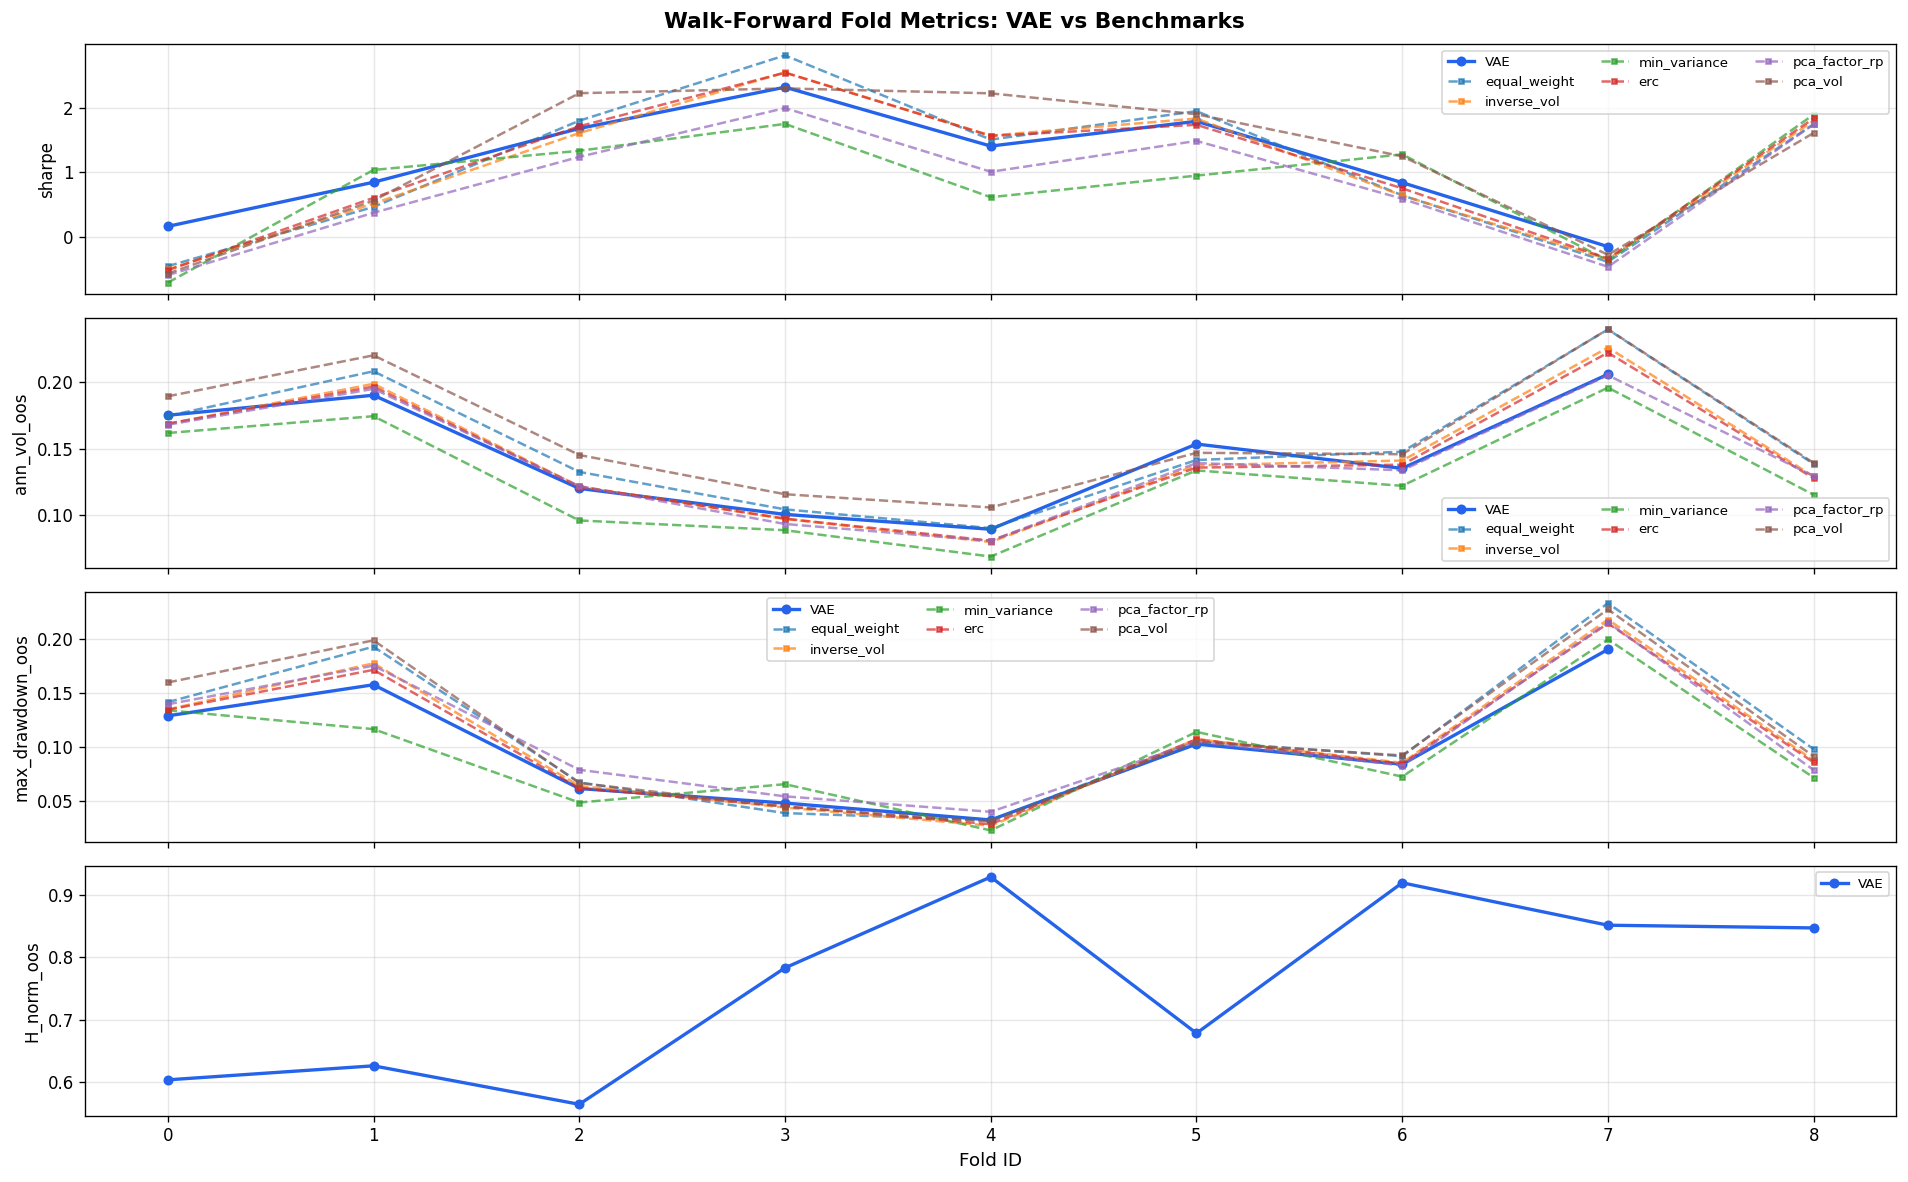

In [35]:
# Fold metrics: VAE vs benchmarks
plot_fold_metrics(results["vae_results"], results["benchmark_results"])
plt.show()

---
## 7. Results - Statistical Tests

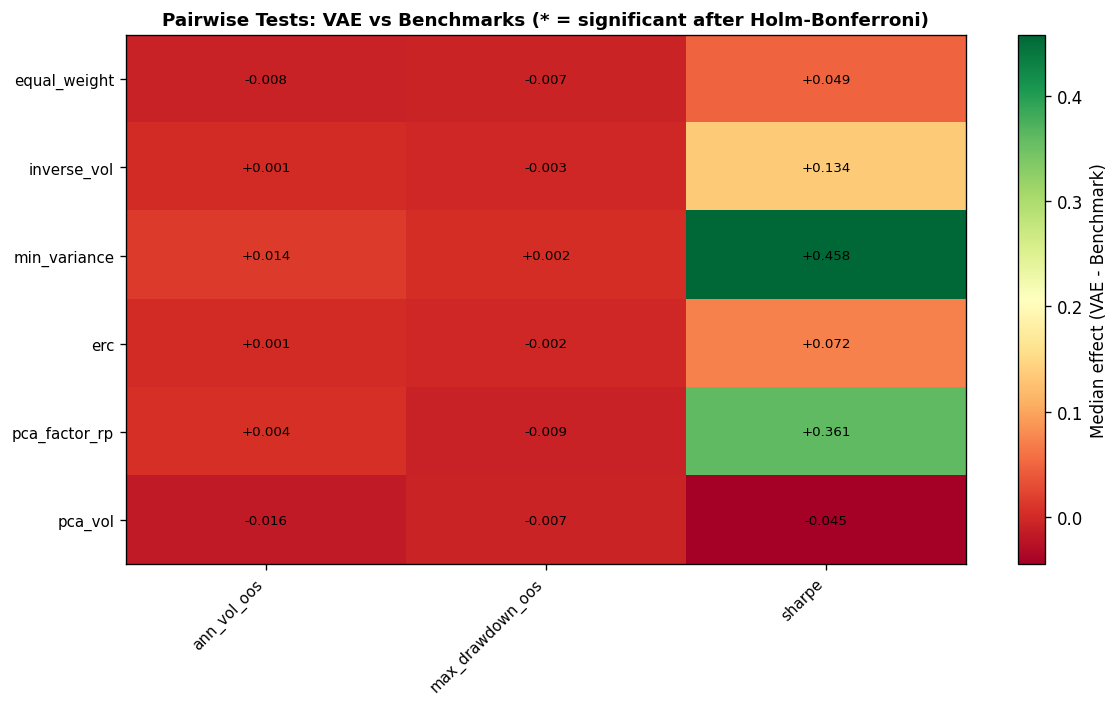

In [36]:
# Pairwise tests heatmap
plot_pairwise_heatmap(results["report"])
plt.show()

In [37]:
# Detailed pairwise test results
tests = results["report"]["statistical_tests"]
print(f"Total comparisons: {tests['n_tests']} (alpha={tests['alpha']})")
print()

for bench_name, metrics in tests["pairwise"].items():
    print(f"VAE vs {bench_name}:")
    for metric, result in metrics.items():
        if result.get("skipped", False):
            print(f"  {metric}: skipped ({result['reason']})")
            continue
        sig = " *" if result.get("significant_corrected", False) else ""
        print(f"  {metric}: delta={result['median_delta']:+.4f} "
              f"[{result['ci_lower']:+.4f}, {result['ci_upper']:+.4f}] "
              f"p={result.get('p_corrected', result['p_value']):.4f}{sig}")
    print()

Total comparisons: 18 (alpha=0.05)

VAE vs equal_weight:
  ann_vol_oos: delta=-0.0081 [-0.0179, +0.0005] p=0.0781
  max_drawdown_oos: delta=-0.0066 [-0.0353, +0.0003] p=0.1094
  sharpe: delta=+0.0489 [-0.1573, +0.3837] p=0.5469

VAE vs inverse_vol:
  ann_vol_oos: delta=+0.0009 [-0.0085, +0.0096] p=0.9453
  max_drawdown_oos: delta=-0.0034 [-0.0199, +0.0041] p=0.1953
  sharpe: delta=+0.1340 [-0.1626, +0.3309] p=0.3125

VAE vs min_variance:
  ann_vol_oos: delta=+0.0145 [+0.0118, +0.0204] p=0.0078
  max_drawdown_oos: delta=+0.0023 [-0.0113, +0.0130] p=0.6406
  sharpe: delta=+0.4579 [-0.1904, +0.8432] p=0.0781

VAE vs erc:
  ann_vol_oos: delta=+0.0010 [-0.0064, +0.0085] p=0.7422
  max_drawdown_oos: delta=-0.0025 [-0.0138, +0.0030] p=0.1484
  sharpe: delta=+0.0716 [-0.1580, +0.2424] p=0.3828

VAE vs pca_factor_rp:
  ann_vol_oos: delta=+0.0043 [-0.0017, +0.0087] p=0.1484
  max_drawdown_oos: delta=-0.0091 [-0.0177, -0.0022] p=0.0156
  sharpe: delta=+0.3615 [+0.3045, +0.4741] p=0.0078

VAE vs p

---
## 8. Export Results

In [28]:
OUTPUT_DIR = "results/"

written = export_results(results, asdict(config), output_dir=OUTPUT_DIR)

print(f"Results saved to {OUTPUT_DIR}")
for path in written:
    print(f"  {os.path.basename(path)}")

Results saved to results/
  vae_fold_metrics.csv
  equal_weight_fold_metrics.csv
  inverse_vol_fold_metrics.csv
  min_variance_fold_metrics.csv
  erc_fold_metrics.csv
  pca_factor_rp_fold_metrics.csv
  pca_vol_fold_metrics.csv
  report.txt
  report.json
  config.json
